In [1]:
import pickle
import time
import itertools
import numpy as np
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import captum
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, Saliency, DeepLift, NoiseTunnel


from resnet20 import Resnet_N_W
from Hparams import Hparams
from utils_Earlystopper import EarlyStopper
import utils
import routines

try:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except NameError or ModuleNotFoundError:
    pass
#setting the path to store/load dataset cifar10
workdir = Path.cwd()
data_path = workdir / "datasets" / "cifar10"
if not data_path.exists():
    data_path.mkdir(parents=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_hparams = Hparams.DatasetHparams(
    test_seed=0,
    val_seed=0,
    train_seed=42,
    split_seed=0,
    rngCrop_seed=0,
    rngRandomHflip_seed=0,
    batch_size=128
)
dataloaderhelper = utils.DataLoaderHelper(
    datasethparams=dataset_hparams
)
trainset = dataloaderhelper.get_trainset(data_path, dataloaderhelper.get_transform(True))
testset = dataloaderhelper.get_testset(data_path, dataloaderhelper.get_transform(False))
trainset, valset = dataloaderhelper.split_train_val(trainset)
trainloader = dataloaderhelper.get_train_loader(trainset)
testloader = dataloaderhelper.get_test_loader(testset)
valloader = dataloaderhelper.get_validation_loader(valset)

invTransformation = transforms.Compose([
    transforms.Normalize(
        mean = [0., 0., 0.],
        std = torch.tensor(dataset_hparams.std).pow(-1)
    ),
    transforms.Normalize(
        mean = -torch.tensor(dataset_hparams.mean),
        std = [ 1., 1., 1. ]),
])

def transform_to_matplotlib(img):
    return np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0))

#######################Set up an image#########################
#get image
img, label = trainset[0]
img_orig = invTransformation(img)
img = img.unsqueeze(0) #dummy batch dimension
img = img.cuda() if torch.cuda.is_available() else img
models, all_model_stats, _1, _2, _3, _4 = routines.load_experiment("e6_1")
winner = models[4]
winner.eval()
#print("Test_acc: ", routines.get_accuracy(device, winner, testloader))
#print("Train_acc: ",routines.get_accuracy(device, winner, trainloader))
#calculate output
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output = winner(img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = classes[int(pred_label_idx.item())]
print('Predicted: ', predicted_label, '(', prediction_score.squeeze().item(), ')')

/home/iai/user/theissin/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified
Predicted:  frog ( 0.9999858140945435 )


In [2]:
#######################Attribution Methods#########################
#####without noise tunnel#####
#Vanilla gradients
saliency = Saliency(winner)
grad = saliency.attribute(img, target=pred_label_idx)
grad_img = transform_to_matplotlib(grad)
#Integrated gradients
integrated_gradients = IntegratedGradients(winner)
attributions_ig = integrated_gradients.attribute(img, target=pred_label_idx, n_steps=200)
attributions_ig_img = transform_to_matplotlib(attributions_ig)
dl = DeepLift(winner)
attributions_dl = dl.attribute(img, target=pred_label_idx)
attributions_dl_img = transform_to_matplotlib(attributions_dl)
#####with noise tunnel#####
#TODO

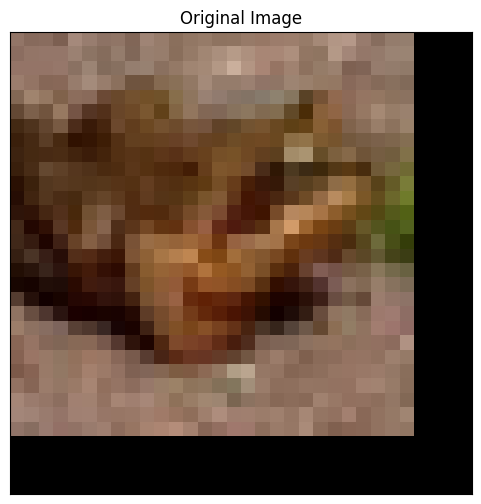

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


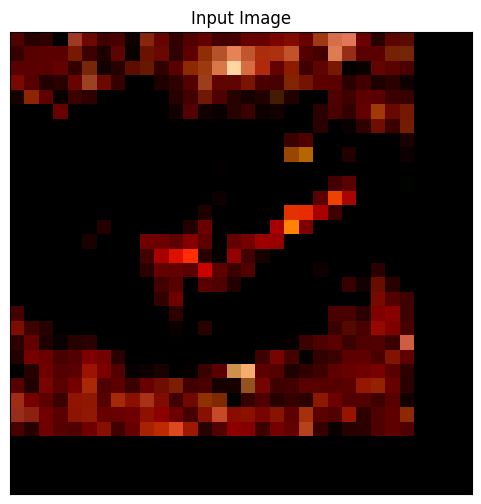

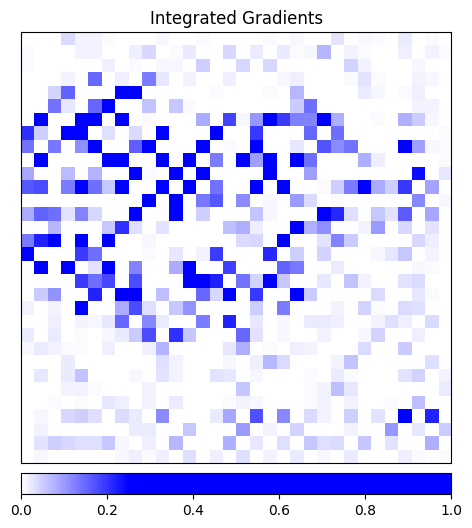

In [3]:
#######################Visualizations#########################
# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(img_orig.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

# Show the input image for comparison
_ = viz.visualize_image_attr(None, np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Input Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')